In [22]:
import jax
import jax.numpy as jnp
import jaxopt
from jax import random
from jaxopt import ScipyMinimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

In [31]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.2
ode_type = "decay"
params = {"c": 1}
start_time=0
end_time=2
spacing_type="chebyshev"
initial_state = jnp.array([1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = jnp.squeeze(y_noisy)

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)

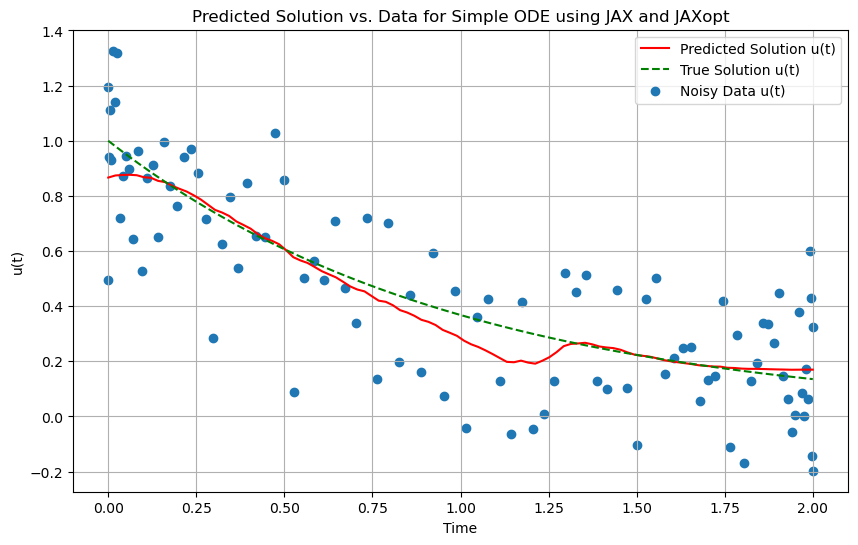

In [43]:
#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def initialize_params(rng, input_size, hidden_size, output_size):
    params = {}
    params['W1'] = random.normal(rng, (hidden_size, input_size)) * 0.1
    params['b1'] = random.normal(rng, (hidden_size,)) * 0.1
    params['W2'] = random.normal(rng, (output_size, hidden_size)) * 0.1
    params['b2'] = random.normal(rng, (output_size,)) * 0.1
    return params

def nn_output(params, t, u):
    inputs = jnp.array([t, u])
    hidden_layer = jnp.tanh(jnp.dot(params['W1'], inputs) + params['b1'])
    output = jnp.dot(params['W2'], hidden_layer) + params['b2']
    return output

#---------------------------LOSS FUNCTION DEFINITION--------------------------#
def loss_fn(params, t, y_noisy, D):
    penalty_lambda = 500

    # Predict states
    y_pred = jax.vmap(lambda i: nn_output(params, t[i], y_noisy[i]))(jnp.arange(N)).reshape(-1)

    def collocation_residual(params, i):
        du_dt = jnp.dot(D[i], y_pred)
        nn_u = nn_output(params, t[i], y_pred[i])
        return (nn_u - du_dt)**2

    # Data fit term
    data_fit = jnp.sum((y_pred - y_noisy)**2)
    
    # Penalty term
    penalty_terms = jax.vmap(lambda i: collocation_residual(params, i))(jnp.arange(1, N))
    penalty = penalty_lambda * jnp.mean(penalty_terms)
    
    return data_fit + 0.002*penalty

#---------------------------INITIALIZE PARAMETERS--------------------------#
rng = random.PRNGKey(0)
input_size = 2
hidden_size = 10
output_size = 1
init_params = initialize_params(rng, input_size, hidden_size, output_size)

#---------------------------OPTIMIZE USING JAXOPT---------------------------#
solver = ScipyMinimize(fun=loss_fn, method="BFGS")

# Run the optimization
opt_params = solver.run(init_params, t=t, y_noisy=y_noisy, D=D).params

#---------------------------PREDICTION FUNCTION---------------------------#
def predict(params, t):
    return jax.vmap(lambda i: nn_output(params, t[i], y_noisy[i]))(jnp.arange(len(t))).reshape(-1)

# Generate predictions using optimized parameters
y_pred = predict(opt_params, t)

#---------------------------INTERPOLATION---------------------------#
interp_fn = interp1d(t, y_pred, kind='cubic', fill_value='extrapolate')
x_new = jnp.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS---------------------------#
plt.figure(figsize=(10, 6))
plt.plot(x_new, y_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y, 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy, label='Noisy Data u(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using JAX and JAXopt')
plt.grid(True)
plt.show()

---

In [72]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = jnp.squeeze(y_noisy)

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)

In [121]:
#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def initialize_params(rng, input_size, hidden_size, output_size):
    params = {}
    params['W1'] = random.normal(rng, (hidden_size, input_size)) * 0.1
    params['b1'] = random.normal(rng, (hidden_size,)) * 0.1
    params['W2'] = random.normal(rng, (output_size, hidden_size)) * 0.1
    params['b2'] = random.normal(rng, (output_size,)) * 0.1
    return params

def nn_output(params, t, u, v):
    inputs = jnp.array([t, u, v])
    hidden_layer = jnp.tanh(jnp.dot(params['W1'], inputs) + params['b1'])
    output = jnp.dot(params['W2'], hidden_layer) + params['b2']
    return output

#---------------------------LOSS FUNCTION DEFINITION--------------------------#
def loss_fn(params, t, y_noisy, D):
    penalty_lambda = 5000
    
    def collocation_residual(params, i):
        du_dt = jnp.dot(D[i], y_pred[:, 0])
        dv_dt = jnp.dot(D[i], y_pred[:, 1])
        nn_u, nn_v = nn_output(params, t[i], y_pred[i, 0], y_pred[i, 1])
        return ((nn_u - du_dt)**2 + (nn_v - dv_dt)**2)/2

    y_pred = jax.vmap(lambda i: nn_output(params, t[i], y_noisy[i, 0], y_noisy[i, 1]))(jnp.arange(N))
    
    data_fit = jnp.sum((y_pred - y_noisy)**2)
    
    penalty_terms = jax.vmap(lambda i: collocation_residual(params, i))(jnp.arange(1, N))
    penalty = penalty_lambda * jnp.mean(penalty_terms)
    
    second_derivative = (jnp.diff(y_pred.T[0], n=3) + jnp.diff(y_pred.T[1], n=3))
    smoothing_term = jnp.sum(second_derivative**2)
    
    return data_fit + 0.001*penalty + 100*smoothing_term

#---------------------------INITIALIZE PARAMETERS--------------------------#
rng = random.PRNGKey(0)
input_size = 3
hidden_size = 20
output_size = 2
init_params = initialize_params(rng, input_size, hidden_size, output_size)

#---------------------------OPTIMIZE USING JAXOPT---------------------------#
solver = ScipyMinimize(fun=loss_fn, method="BFGS")

opt_params = solver.run(init_params, t=t, y_noisy=y_noisy, D=D).params

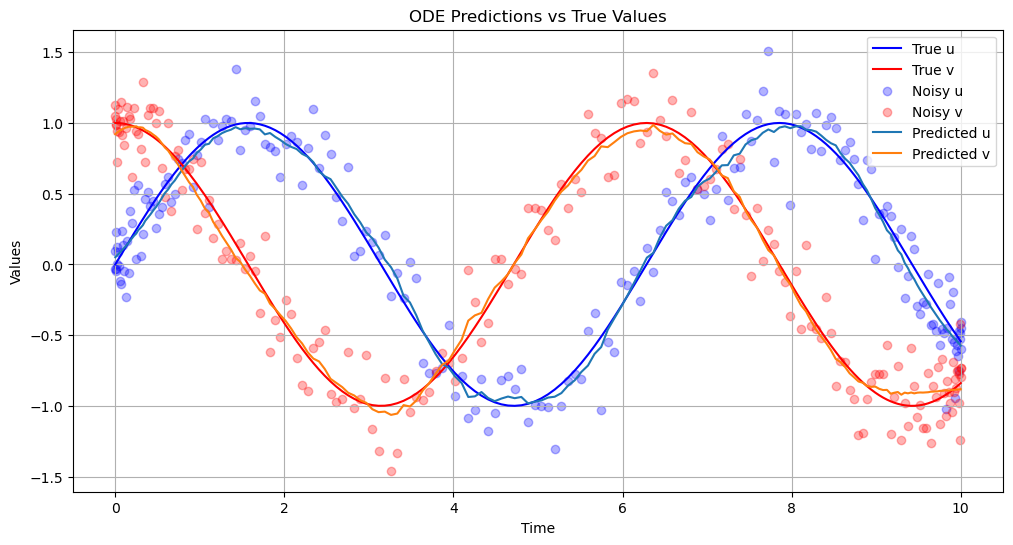

In [122]:
def predict(params, t, y_noisy):
    return jax.vmap(lambda i: nn_output(params, t[i], y_noisy[i, 0], y_noisy[i, 1]))(jnp.arange(len(t)))

y_pred = predict(opt_params, t, y_noisy)

#---------------------------PLOT PREDICTIONS---------------------------#
plt.figure(figsize=(12, 6))

plt.plot(t, y[:, 0], label='True u', color='blue')
plt.plot(t, y[:, 1], label='True v', color='red')

plt.scatter(t, y_noisy[:, 0], label='Noisy u', color='blue', alpha=0.3)
plt.scatter(t, y_noisy[:, 1], label='Noisy v', color='red', alpha=0.3)

plt.plot(t, y_pred[:, 0], label='Predicted u')
plt.plot(t, y_pred[:, 1], label='Predicted v')

plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('ODE Predictions vs True Values')
plt.grid()
plt.show()